In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import  ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
houses = pd.read_csv('data.csv')
houses

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.60,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.20,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.70,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.10,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.70,15.2,4.0,5.0,5,Without renovation
...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,New building,Котельники,8.0,Moscow region,0.0,31.75,13.0,5.0,4.0,17,Cosmetic
22672,5900000.0,New building,Домодедовская,25.0,Moscow region,1.0,31.60,10.1,12.2,11.0,15,Cosmetic
22673,3700000.0,New building,Котельники,30.0,Moscow region,0.0,18.00,15.0,8.1,17.0,17,Cosmetic
22674,5768869.0,New building,Жулебино,14.0,Moscow region,2.0,36.39,22.0,6.6,12.0,14,Cosmetic


In [3]:
aparts = pd.get_dummies(houses['Apartment type']) 
with_aparts = houses.join(aparts)
hs1 = with_aparts.drop(['Apartment type'], axis = 1)


metro = pd.get_dummies(hs1['Metro station']) 
with_metro = hs1.join(metro)
hs2 = with_metro.drop(['Metro station'], axis = 1)


reg = pd.get_dummies(hs2['Region']) 
with_reg = hs2.join(reg)
hs3 = with_reg.drop(['Region'], axis = 1)


ren = pd.get_dummies(hs3['Renovation']) 
with_ren = hs3.join(ren)
hs = with_ren.drop(['Renovation'], axis = 1)


hs

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,New building,Secondary,...,Юго-Западная,Южная,Ясенево,Яхромская,Moscow,Moscow region,Cosmetic,Designer,European-style renovation,Without renovation
0,6300000.0,6.0,1.0,30.60,11.1,8.5,25.0,25,False,True,...,False,False,False,False,False,True,True,False,False,False
1,9000000.0,2.0,1.0,49.20,20.0,10.0,6.0,15,False,True,...,False,False,False,False,False,True,False,False,True,False
2,11090000.0,14.0,1.0,44.70,16.2,13.1,10.0,25,False,True,...,False,False,False,False,False,True,True,False,False,False
3,8300000.0,8.0,1.0,35.10,16.0,11.0,12.0,33,False,True,...,False,False,False,False,False,True,False,False,True,False
4,6450000.0,6.0,1.0,37.70,15.2,4.0,5.0,5,False,True,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,8.0,0.0,31.75,13.0,5.0,4.0,17,True,False,...,False,False,False,False,False,True,True,False,False,False
22672,5900000.0,25.0,1.0,31.60,10.1,12.2,11.0,15,True,False,...,False,False,False,False,False,True,True,False,False,False
22673,3700000.0,30.0,0.0,18.00,15.0,8.1,17.0,17,True,False,...,False,False,False,False,False,True,True,False,False,False
22674,5768869.0,14.0,2.0,36.39,22.0,6.6,12.0,14,True,False,...,False,False,False,False,False,True,True,False,False,False


In [4]:
no_nan_hs = hs.dropna(how = 'any')
no_nan_hs
X = no_nan_hs.drop(['Price'],axis = 1)
y = no_nan_hs['Price']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
pipe_rofl = Pipeline([('scaler', StandardScaler()), ('linreg', ElasticNet())])

In [7]:
pipe_rofl.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('linreg', ElasticNet())])

In [8]:
print(f'Первое это Score {pipe_rofl.score(X_test, y_test)}', 
      f'Второе это MSE {mean_squared_error(pipe_rofl.predict(X_test), y_test)}', 
      f'Третье это MAE {mean_absolute_error(pipe_rofl.predict(X_test), y_test)}')


Первое это Score 0.7093863712849813 Второе это MSE 1834265293171072.0 Третье это MAE 16887020.297691986


In [9]:
forest = RandomForestRegressor()
params = {'forest__n_estimators' : [10**i for i in range(3)],
          'forest__criterion' : ["squared_error"],
          'forest__max_depth' : [None, 10, 20]
          }
pipe = Pipeline([('scaler', StandardScaler()), ('forest', forest)])
grid =  GridSearchCV(pipe, params)

In [10]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('forest', RandomForestRegressor())]),
             param_grid={'forest__criterion': ['squared_error'],
                         'forest__max_depth': [None, 10, 20],
                         'forest__n_estimators': [1, 10, 100]})

In [11]:
model = grid.best_estimator_

print(f'Лучшие параметры модели Леса: {grid.best_params_}')
pkl_filename = "pickle_model.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(model, file)

Лучшие параметры модели Леса: {'forest__criterion': 'squared_error', 'forest__max_depth': None, 'forest__n_estimators': 100}


In [13]:
with open('pickle_model.pkl', 'rb') as file: 
            pickle_model = pickle.load(file)
grid = pickle_model

print(f'Score: {grid.score(X_test,y_test)}', 
      f'MSE: {mean_squared_error(grid.predict(X_test), y_test)}', 
      f'MAE: {mean_absolute_error(grid.predict(X_test), y_test)}')

Score: 0.8645995762222644 MSE: 854606506633253.9 MAE: 7678138.528843765


In [14]:
scaler = StandardScaler()
#Вычисление среднего и стандартного отклонения для каждого признака, 
#и масштабирование путем вычитания среднего и деления на стандартное отклонение.
hs_trans = scaler.fit_transform(hs)

In [15]:
class CustomDataset(Dataset):
    # Конструктор класса. Принимает входные данные X и метки y.
    def __init__(self, X, y):

        self.X = X
        self.y = y
    
    # Метод, возвращающий длину датасета (количество элементов).
    def __len__(self):
        
        return len(self.X)

    # Метод, позволяющий получить элемент датасета по индексу idx.
    def __getitem__(self, idx):
    # Возвращает кортеж из X[idx] и y[idx], то есть признаки и соответствующую им метку.
        return self.X[idx], self.y[idx]

In [16]:
Xt = hs.drop(['Price'], axis = 1)
yt = hs['Price']
# Масштабируем признаки в Xt
Xt_trans = scaler.fit_transform(Xt)
# Масштабируем целевую переменную yt
yt_trans = scaler.fit_transform(np.array(yt).reshape(-1,1))
yt_trans = scaler.inverse_transform(np.array(yt_trans).reshape(-1,1))
print(yt_trans)
# Преобразуем массивы в тензоры PyTorch
Xt = torch.tensor(Xt_trans)
yt = torch.tensor(yt_trans)

# Заменяем NaN значения в Xt на 0.0
Xt = torch.nan_to_num(Xt, nan = 0.0)

# Проверяем наличие NaN и бесконечных значений в данных
for batch in zip(Xt, yt):
    X, y = batch
    
    assert not torch.isnan(X).any(), "X contains NaN"
    assert not torch.isinf(X).any(), "X contains Inf"
    assert not torch.isnan(y).any(), "y contains NaN"
    assert not torch.isinf(y).any(), "y contains Inf"
print(y.shape)

# Разделяем данные на обучающую и тестовую выборки
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt)


[[ 6300000.]
 [ 9000000.]
 [11090000.]
 ...
 [ 3700000.]
 [ 5768869.]
 [ 6839157.]]
torch.Size([1])


In [17]:
# Создаем объекты набора данных (dataset) для обучающей и тестовой выборок с помощью пользовательского класса CustomDataset.
# Xt_train - матрица признаков обучающей выборки, yt_train - вектор целевых значений обучающей выборки.
# Xt_test - матрица признаков тестовой выборки, yt_test - вектор целевых значений тестовой выборки.
dt_train = CustomDataset(Xt_train,yt_train)
dt_test = CustomDataset(Xt_test,yt_test)

In [18]:
# Создаем загрузчики данных для обучающей и тестовой выборок с помощью DataLoader.
# dt_train - набор данных обучающей выборки, dt_test - набор данных тестовой выборки.
# batch_size=128 означает, что данные будут загружаться пакетами по 128 элементов.
dt_tr_loader = DataLoader(dt_train, batch_size=128)
dt_ts_loader = DataLoader(dt_test, batch_size=128)


for batch in dt_ts_loader:
    print(batch[0].shape)
    break

torch.Size([128, 562])


In [19]:
class LinearModel(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                nn.Linear(562, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 512),
                nn.LeakyReLU(),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 128),
                nn.LeakyReLU(),
                nn.Linear(128, 64),
                nn.LeakyReLU(),
                nn.Linear(64, 32),
                nn.LeakyReLU(),
                nn.Linear(32, 1)
        )
    def forward(self, X):
        return self.network(X)

In [20]:
#Определяем устройство, на котором будет выполняться вычисление (в данном случае - GPU с помощью CUDA)
device = "cuda"
device

'cuda'

In [33]:
model = LinearModel()
model.to(device)

LinearModel(
  (network): Sequential(
    (0): Linear(in_features=562, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=256, out_features=256, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): LeakyReLU(negative_slope=0.01)
    (18): Linear(in_features=128, ou

In [34]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):
    
    #Здесь создаются массивы для сохранения значений потерь и точности как для обучения, так и для тестирования на каждой эпохе.
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    #Этот цикл выполняет обучение на протяжении заданного числа эпох.
    for i_epoch in (range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        # В этом блоке происходит проход по всему обучающему набору данных. 
        # Модель делает прямой проход (forward-pass), затем вычисляется потеря (loss), происходит обратный проход (backward-pass) и обновление весов с помощью оптимизатора
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            # model forward-pass
            preds = model(X.float())

            # model backward-pass
            optimizer.zero_grad()
            loss = criterion(preds, y.float())
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        # Тестирование модели на отдельном тестовом наборе данных
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X.float())
                loss = criterion(preds, y.float())

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy
        print(f'номер эпохи {i_epoch + 1}, test loss = {test_loss}')

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

In [35]:
# Cреднеквадратичная ошибка 
criterion_1 = nn.MSELoss()
# Абсолютная ошибка
criterion_2 = nn.L1Loss()
# Оптимизатор для обучения модели, lr=0.0001 задаёт скорость обучения (learning rate) для оптимизатора.
optimize = torch.optim.AdamW(model.parameters(), lr=0.00001)

In [36]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(model, criterion=criterion_1,
                              optimizer=optimize,
                              train_dataloader=dt_tr_loader,
                              test_dataloader=dt_ts_loader,
                              num_epochs=50)

номер эпохи 1, test loss = 7411096230617998.0
номер эпохи 2, test loss = 7411096224652766.0
номер эпохи 3, test loss = 7411083318872565.0
номер эпохи 4, test loss = 7410495433293460.0
номер эпохи 5, test loss = 7400387206884011.0
номер эпохи 6, test loss = 7307563583289572.0
номер эпохи 7, test loss = 6784408959541430.0
номер эпохи 8, test loss = 5211382471085989.0
номер эпохи 9, test loss = 3984967857707417.5
номер эпохи 10, test loss = 3793912235585991.0
номер эпохи 11, test loss = 3674964451044010.5
номер эпохи 12, test loss = 3574240749609870.0
номер эпохи 13, test loss = 3484587050489173.5
номер эпохи 14, test loss = 3402654964369180.5
номер эпохи 15, test loss = 3326562810899114.5
номер эпохи 16, test loss = 3255205899138207.5
номер эпохи 17, test loss = 3187864282210850.0
номер эпохи 18, test loss = 3124094057351304.5
номер эпохи 19, test loss = 3063516949788899.5
номер эпохи 20, test loss = 3005917462522174.5
номер эпохи 21, test loss = 2951114571627451.5
номер эпохи 22, test l

In [37]:
train_losses_mae, test_losses_mae, a, b = train(model, criterion=criterion_2,
                              optimizer=optimize,
                              train_dataloader=dt_tr_loader,
                              test_dataloader=dt_ts_loader,
                              num_epochs=80
                              )

номер эпохи 1, test loss = 18002189.666666668
номер эпохи 2, test loss = 17998916.777777776
номер эпохи 3, test loss = 17995650.155555554
номер эпохи 4, test loss = 17992384.48888889
номер эпохи 5, test loss = 17989124.666666668
номер эпохи 6, test loss = 17985865.844444446
номер эпохи 7, test loss = 17982608.244444445
номер эпохи 8, test loss = 17979351.68888889
номер эпохи 9, test loss = 17976095.444444444
номер эпохи 10, test loss = 17972840.466666665
номер эпохи 11, test loss = 17969585.68888889
номер эпохи 12, test loss = 17966331.533333335
номер эпохи 13, test loss = 17963078.0
номер эпохи 14, test loss = 17959825.17777778
номер эпохи 15, test loss = 17956572.533333335
номер эпохи 16, test loss = 17953321.02222222
номер эпохи 17, test loss = 17950069.71111111
номер эпохи 18, test loss = 17946820.266666666
номер эпохи 19, test loss = 17943572.888888888
номер эпохи 20, test loss = 17940327.044444446
номер эпохи 21, test loss = 17937082.866666667
номер эпохи 22, test loss = 17933851

In [38]:
basic_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_losses_mae = train_losses_mae,
    test_losses_mae = test_losses_mae
)

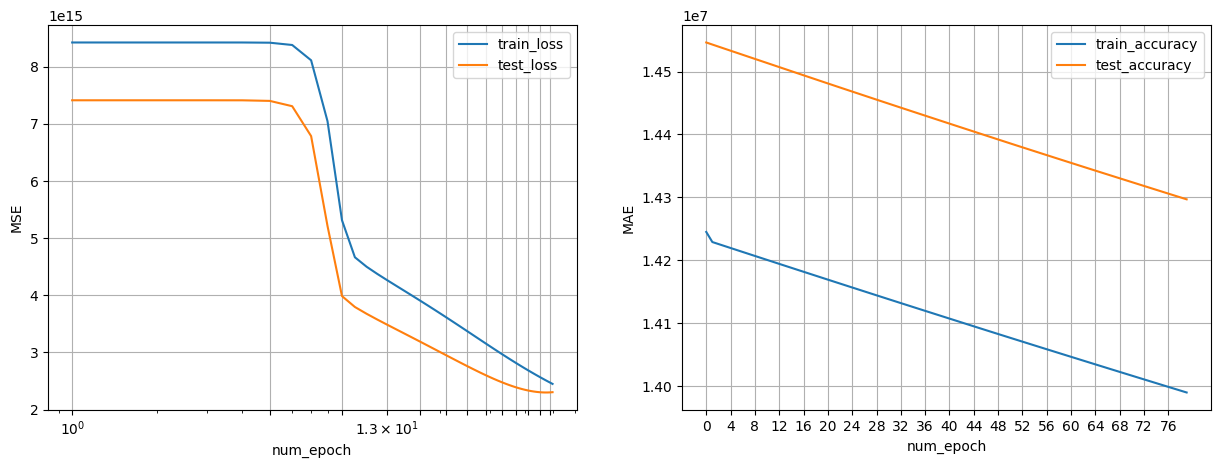

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].semilogx(np.arange(1, train_losses.shape[0] + 1), train_losses, label='train_loss')
ax[0].semilogx(np.arange(1, test_losses.shape[0] + 1), test_losses, label='test_loss')
ax[0].set_xticks(np.arange(1, train_losses.shape[0] + 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_losses_mae.shape[0]), train_losses_mae - 0.3456 * 10**7 ,
           label='train_accuracy')
ax[1].plot(np.arange(test_losses_mae.shape[0]), test_losses_mae - 0.3456 * 10**7,
           label='test_accuracy')
ax[1].set_xticks(np.arange(0, train_losses_mae.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].grid()
#plt.savefig('grafiki.png')
plt.show()

In [76]:
torch.save(model, 'model_igor.pth')